In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


0     -0.025547
1      0.092241
2      0.091614
3     -0.029861
4     -0.081061
5     -0.081246
6      0.075370
7     -0.018363
8     -0.065202
9      0.064017
10     0.035250
11    -0.054299
12    -0.080261
13     0.032733
14     0.039559
15     0.112890
16     0.014132
17    -0.040457
18    -0.143370
19    -0.080158
20    -0.046180
21     0.160100
22     0.036908
23    -0.030857
24    -0.161610
25    -0.074868
26     0.005449
27     0.152760
28     0.140540
29    -0.030355
         ...   
690    0.113130
691    0.056119
692    0.011284
693   -0.050664
694    0.034800
695    0.017427
696   -0.019294
697    0.021388
698   -0.028952
699    0.038371
700   -0.045308
701    0.046826
702   -0.042584
703   -0.030396
704   -0.001803
705    0.018636
706   -0.016862
707    0.022332
708   -0.035619
709    0.000859
710    0.048474
711    0.129500
712    0.167110
713    0.182690
714   -0.007033
715   -0.275650
716   -0.291690
717   -0.140830
718    0.089041
719    0.410710
Name: f0, Length: 720, d

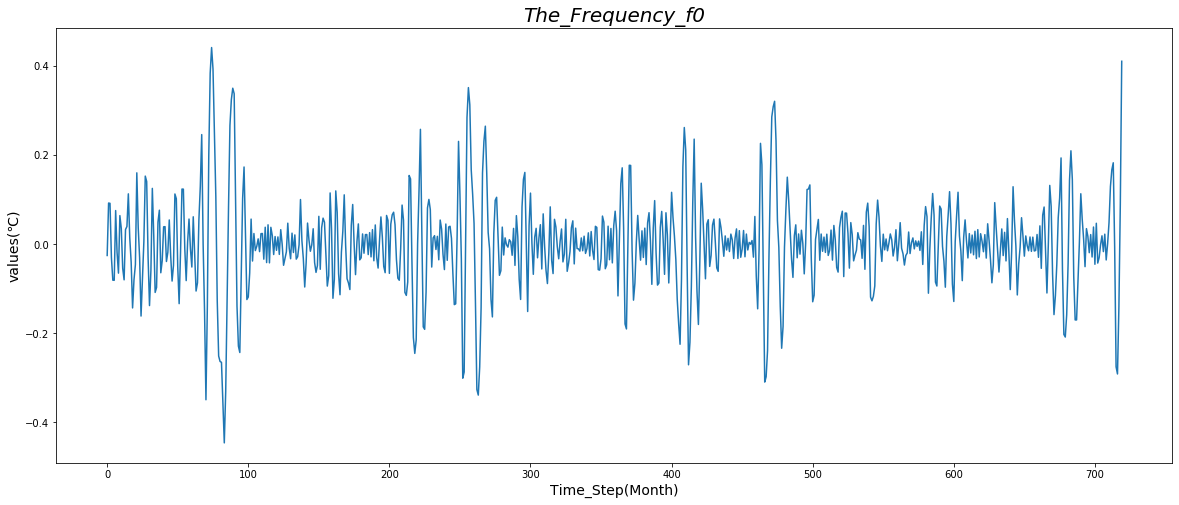

[[[-2.5547e-02]
  [ 9.2241e-02]
  [ 9.1614e-02]
  [-2.9861e-02]
  [-8.1061e-02]
  [-8.1246e-02]
  [ 7.5370e-02]
  [-1.8363e-02]
  [-6.5202e-02]
  [ 6.4017e-02]
  [ 3.5250e-02]
  [-5.4299e-02]]

 [[-8.0261e-02]
  [ 3.2733e-02]
  [ 3.9559e-02]
  [ 1.1289e-01]
  [ 1.4132e-02]
  [-4.0457e-02]
  [-1.4337e-01]
  [-8.0158e-02]
  [-4.6180e-02]
  [ 1.6010e-01]
  [ 3.6908e-02]
  [-3.0857e-02]]

 [[-1.6161e-01]
  [-7.4868e-02]
  [ 5.4492e-03]
  [ 1.5276e-01]
  [ 1.4054e-01]
  [-3.0355e-02]
  [-1.3808e-01]
  [-5.8738e-02]
  [ 1.2519e-01]
  [ 1.9747e-02]
  [-1.0855e-01]
  [-9.7296e-02]]

 [[ 4.9602e-02]
  [ 7.6171e-02]
  [-6.4388e-02]
  [-3.7326e-02]
  [ 3.8834e-02]
  [ 3.9240e-02]
  [-3.9069e-02]
  [-1.8257e-02]
  [ 5.4259e-02]
  [-2.5882e-02]
  [-8.3007e-02]
  [-4.7521e-02]]

 [[ 1.1258e-01]
  [ 1.0203e-01]
  [-5.0122e-02]
  [-1.3377e-01]
  [-1.6454e-02]
  [ 1.2364e-01]
  [ 1.2345e-01]
  [-1.0158e-02]
  [-8.2005e-02]
  [ 4.5278e-03]
  [ 5.6274e-02]
  [-1.0434e-02]]

 [[-5.1485e-02]
  [ 6.1355e-02

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 6s - loss: 0.0109
Epoch 2/200
 - 2s - loss: 0.0108
Epoch 3/200
 - 2s - loss: 0.0108
Epoch 4/200
 - 2s - loss: 0.0108
Epoch 5/200
 - 2s - loss: 0.0108
Epoch 6/200
 - 2s - loss: 0.0108
Epoch 7/200
 - 2s - loss: 0.0108
Epoch 8/200
 - 2s - loss: 0.0108
Epoch 9/200
 - 2s - loss: 0.0108
Epoch 10/200
 - 2s - loss: 0.0108
Epoch 11/200
 - 2s - loss: 0.0107
Epoch 12/200
 - 2s - loss: 0.0107
Epoch 13/200
 - 2s - loss: 0.0105
Epoch 14/200
 - 2s - loss: 0.0104
Epoch 15/200
 - 2s - loss: 0.0100
Epoch 16/200
 - 2s - loss: 0.0098
Epoch 17/200
 - 2s - loss: 0.0096
Epoch 18/200
 - 2s - loss: 0.0094
Epoch 19/200
 - 2s - loss: 0.0095
Epoch 20/200
 - 2s - loss: 0.0091
Epoch 21/200
 - 2s - loss: 0.0088
Epoch 22/200
 - 3s - loss: 0.0085
Epoch 23/200
 - 3s - loss: 0.0084
Epoch 24/200
 - 3s - loss: 0.0083
Epoch 25/200
 - 3s - loss: 0.0081
Epoch 26/200
 - 4s - loss: 0.0081
Epoch 27/200
 - 3s - loss: 0.0079
Epoch 28/200
 - 3s - loss: 0.0079
Epoch 29/

(57, 12)


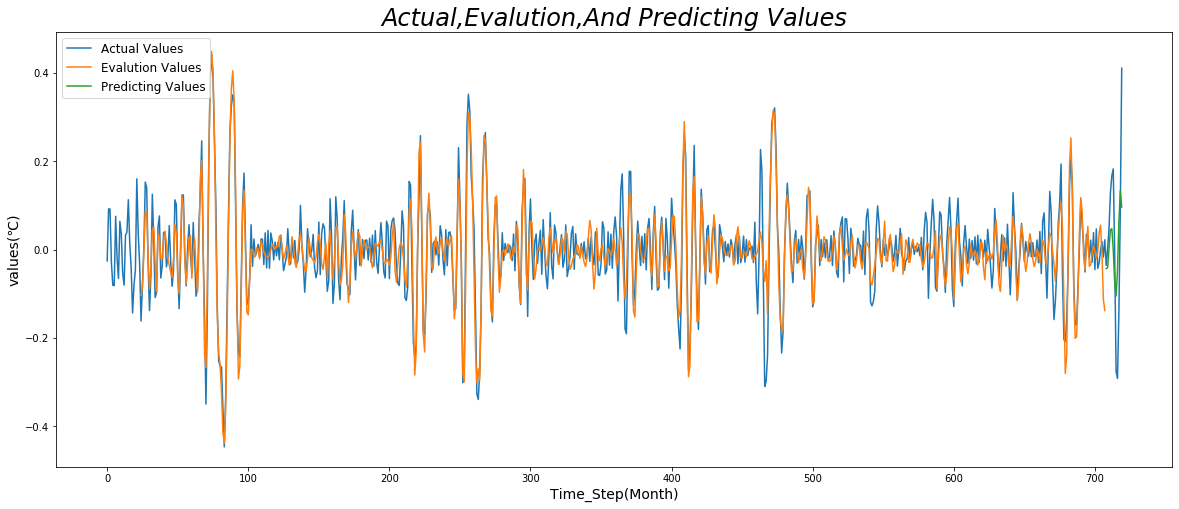

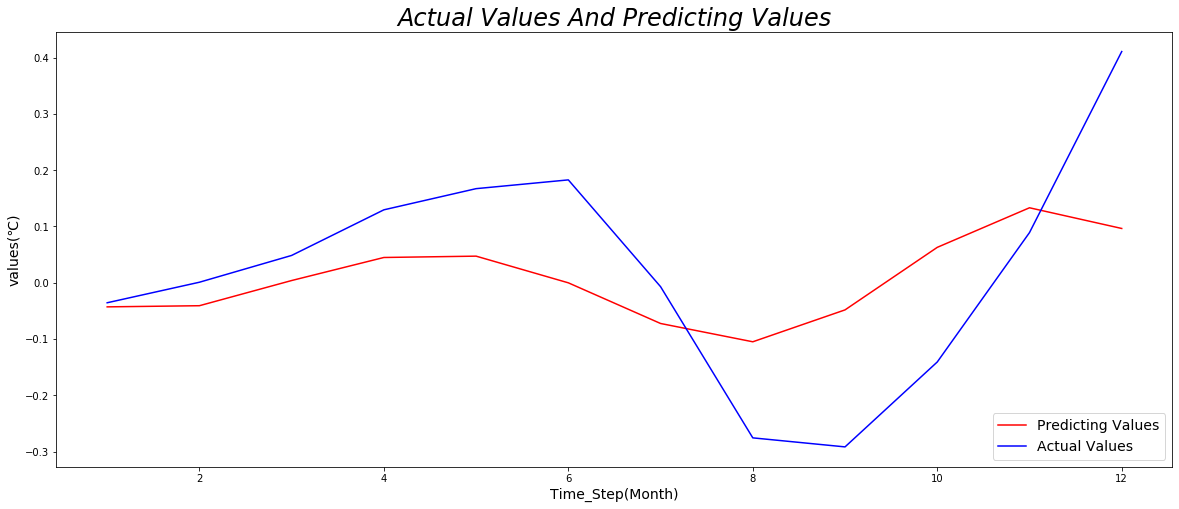

0     -0.294540
1     -0.206260
2     -0.114940
3     -0.018285
4      0.092434
5      0.236340
6      0.407510
7      0.512940
8      0.455400
9      0.206520
10    -0.097637
11    -0.351990
12    -0.478850
13    -0.451500
14    -0.319580
15    -0.149650
16     0.002985
17     0.128160
18     0.224470
19     0.283560
20     0.306910
21     0.296920
22     0.250800
23     0.176900
24     0.086898
25    -0.006406
26    -0.085830
27    -0.131520
28    -0.123820
29    -0.071080
         ...   
690   -0.143730
691   -0.282870
692   -0.436790
693   -0.578930
694   -0.676550
695   -0.682130
696   -0.581730
697   -0.373990
698   -0.092222
699    0.153170
700    0.329120
701    0.507090
702    0.642710
703    0.651090
704    0.517000
705    0.269650
706   -0.037233
707   -0.328340
708   -0.525900
709   -0.615760
710   -0.610160
711   -0.528340
712   -0.390740
713   -0.216030
714   -0.018192
715    0.179080
716    0.347050
717    0.474100
718    0.550870
719    0.566740
Name: f1, Length: 720, d

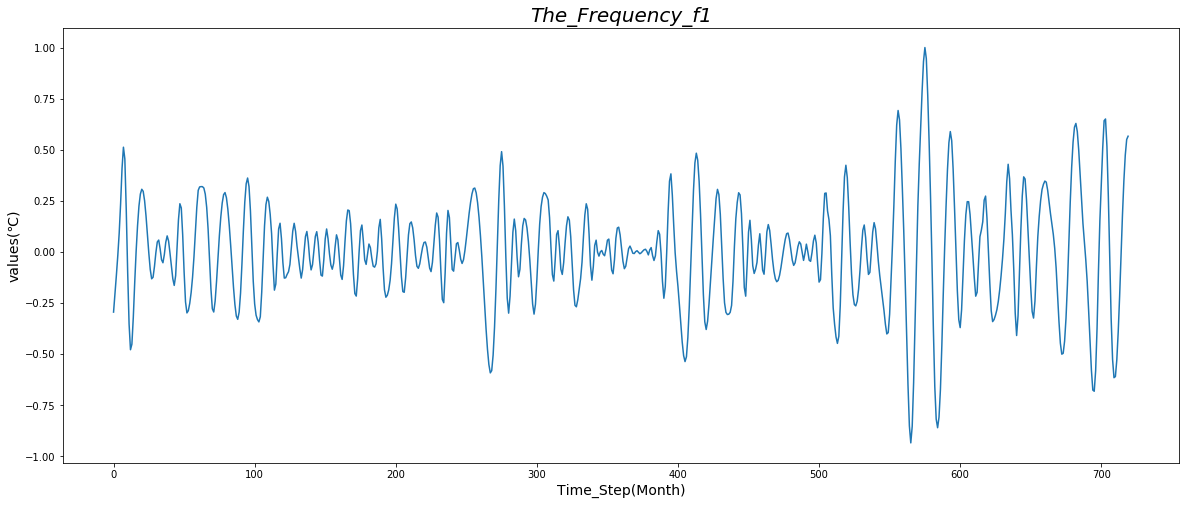

[[[-2.9454e-01]
  [-2.0626e-01]
  [-1.1494e-01]
  [-1.8285e-02]
  [ 9.2434e-02]
  [ 2.3634e-01]
  [ 4.0751e-01]
  [ 5.1294e-01]
  [ 4.5540e-01]
  [ 2.0652e-01]
  [-9.7637e-02]
  [-3.5199e-01]]

 [[-4.7885e-01]
  [-4.5150e-01]
  [-3.1958e-01]
  [-1.4965e-01]
  [ 2.9850e-03]
  [ 1.2816e-01]
  [ 2.2447e-01]
  [ 2.8356e-01]
  [ 3.0691e-01]
  [ 2.9692e-01]
  [ 2.5080e-01]
  [ 1.7690e-01]]

 [[ 8.6898e-02]
  [-6.4059e-03]
  [-8.5830e-02]
  [-1.3152e-01]
  [-1.2382e-01]
  [-7.1080e-02]
  [-3.0445e-03]
  [ 4.8778e-02]
  [ 5.8154e-02]
  [ 1.5810e-02]
  [-3.7963e-02]
  [-5.2927e-02]]

 [[-1.2426e-02]
  [ 4.7069e-02]
  [ 7.8590e-02]
  [ 5.3272e-02]
  [-5.8918e-03]
  [-6.9886e-02]
  [-1.3140e-01]
  [-1.6388e-01]
  [-1.1630e-01]
  [ 1.6081e-02]
  [ 1.5718e-01]
  [ 2.3609e-01]]

 [[ 2.1549e-01]
  [ 8.3197e-02]
  [-9.7596e-02]
  [-2.4477e-01]
  [-2.9853e-01]
  [-2.8754e-01]
  [-2.5153e-01]
  [-1.9811e-01]
  [-1.2294e-01]
  [-2.2837e-02]
  [ 9.6141e-02]
  [ 2.1869e-01]]

 [[ 3.0174e-01]
  [ 3.1849e-01

Epoch 1/200
 - 15s - loss: 0.0619
Epoch 2/200
 - 3s - loss: 0.0562
Epoch 3/200
 - 3s - loss: 0.0498
Epoch 4/200
 - 3s - loss: 0.0450
Epoch 5/200
 - 3s - loss: 0.0426
Epoch 6/200
 - 2s - loss: 0.0409
Epoch 7/200
 - 2s - loss: 0.0408
Epoch 8/200
 - 2s - loss: 0.0384
Epoch 9/200
 - 2s - loss: 0.0350
Epoch 10/200
 - 2s - loss: 0.0348
Epoch 11/200
 - 2s - loss: 0.0323
Epoch 12/200
 - 2s - loss: 0.0306
Epoch 13/200
 - 2s - loss: 0.0306
Epoch 14/200
 - 2s - loss: 0.0302
Epoch 15/200
 - 2s - loss: 0.0293
Epoch 16/200
 - 2s - loss: 0.0285
Epoch 17/200
 - 2s - loss: 0.0279
Epoch 18/200
 - 2s - loss: 0.0283
Epoch 19/200
 - 2s - loss: 0.0277
Epoch 20/200
 - 2s - loss: 0.0261
Epoch 21/200
 - 3s - loss: 0.0280
Epoch 22/200
 - 3s - loss: 0.0264
Epoch 23/200
 - 3s - loss: 0.0270
Epoch 24/200
 - 3s - loss: 0.0258
Epoch 25/200
 - 3s - loss: 0.0274
Epoch 26/200
 - 3s - loss: 0.0254
Epoch 27/200
 - 3s - loss: 0.0242
Epoch 28/200
 - 3s - loss: 0.0251
Epoch 29/200
 - 3s - loss: 0.0238
Epoch 30/200
 - 3s - l

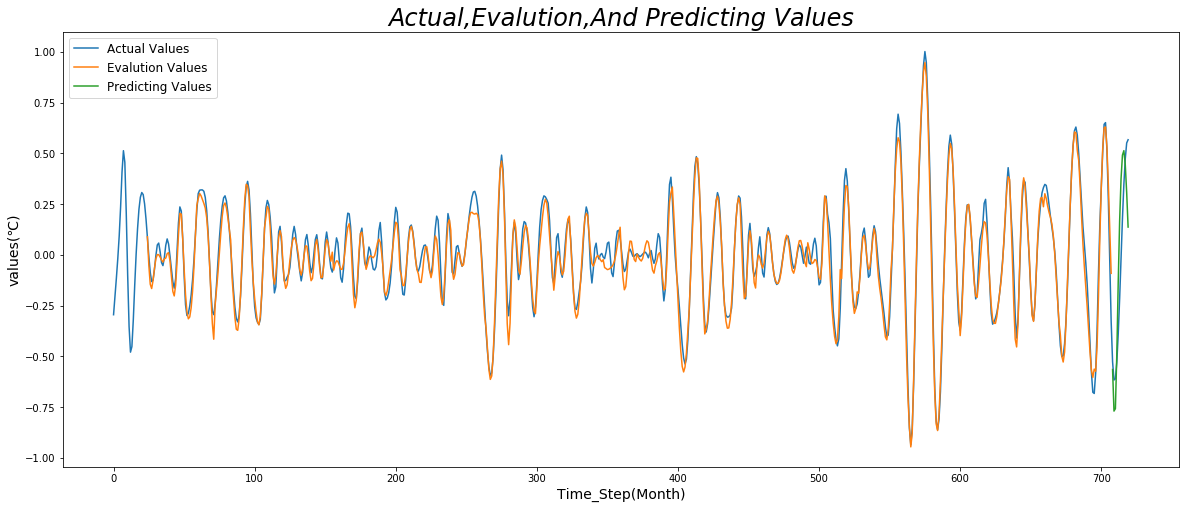

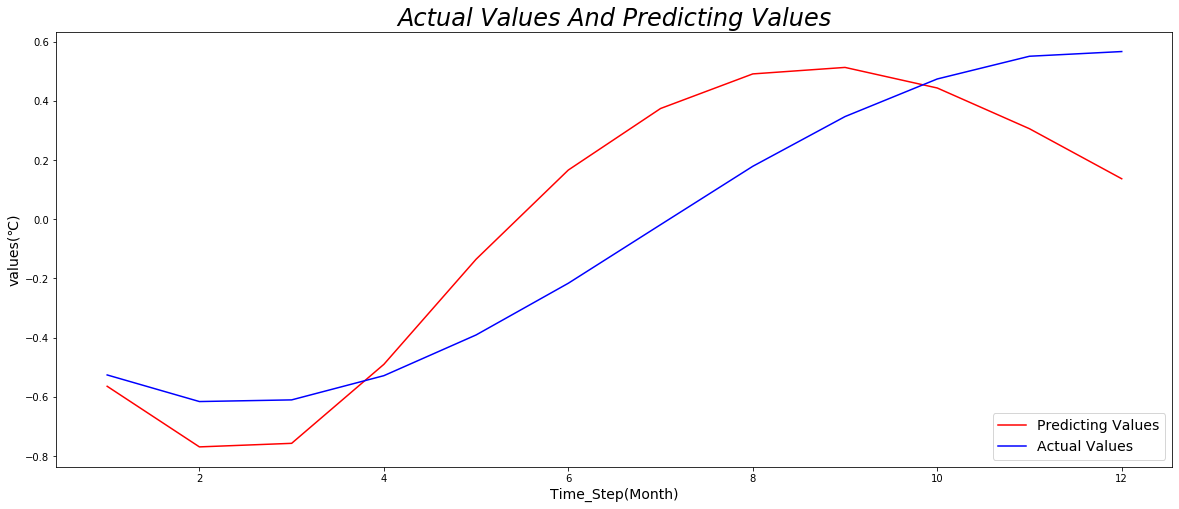

0     -0.438890
1     -0.456720
2     -0.466010
3     -0.466450
4     -0.457420
5     -0.438230
6     -0.408210
7     -0.366670
8     -0.313070
9     -0.247670
10    -0.171950
11    -0.087650
12     0.003699
13     0.100570
14     0.198250
15     0.291170
16     0.373790
17     0.440530
18     0.485840
19     0.504150
20     0.489910
21     0.439690
22     0.358500
23     0.253460
24     0.131690
25     0.000284
26    -0.133640
27    -0.262960
28    -0.380460
29    -0.478240
         ...   
690   -0.095109
691   -0.202750
692   -0.309500
693   -0.412450
694   -0.508710
695   -0.595380
696   -0.669730
697   -0.729690
698   -0.773390
699   -0.798910
700   -0.804370
701   -0.787890
702   -0.747490
703   -0.681200
704   -0.588300
705   -0.473200
706   -0.341580
707   -0.199120
708   -0.051520
709    0.095783
710    0.238560
711    0.374040
712    0.499750
713    0.613220
714    0.711980
715    0.793560
716    0.855500
717    0.895320
718    0.910510
719    0.898810
Name: f2, Length: 720, d

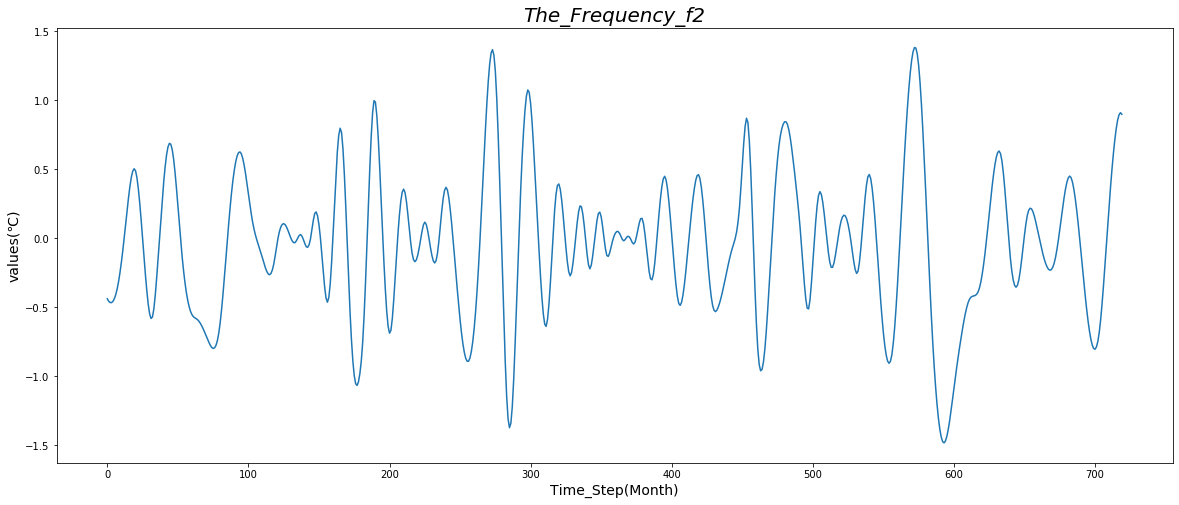

[[[-4.3889e-01]
  [-4.5672e-01]
  [-4.6601e-01]
  [-4.6645e-01]
  [-4.5742e-01]
  [-4.3823e-01]
  [-4.0821e-01]
  [-3.6667e-01]
  [-3.1307e-01]
  [-2.4767e-01]
  [-1.7195e-01]
  [-8.7650e-02]]

 [[ 3.6991e-03]
  [ 1.0057e-01]
  [ 1.9825e-01]
  [ 2.9117e-01]
  [ 3.7379e-01]
  [ 4.4053e-01]
  [ 4.8584e-01]
  [ 5.0415e-01]
  [ 4.8991e-01]
  [ 4.3969e-01]
  [ 3.5850e-01]
  [ 2.5346e-01]]

 [[ 1.3169e-01]
  [ 2.8436e-04]
  [-1.3364e-01]
  [-2.6296e-01]
  [-3.8046e-01]
  [-4.7824e-01]
  [-5.4803e-01]
  [-5.8184e-01]
  [-5.7069e-01]
  [-5.1160e-01]
  [-4.1193e-01]
  [-2.8498e-01]]

 [[-1.4410e-01]
  [ 2.5337e-03]
  [ 1.4806e-01]
  [ 2.8598e-01]
  [ 4.1120e-01]
  [ 5.1893e-01]
  [ 6.0420e-01]
  [ 6.6199e-01]
  [ 6.8813e-01]
  [ 6.8186e-01]
  [ 6.4337e-01]
  [ 5.7378e-01]]

 [[ 4.7821e-01]
  [ 3.6393e-01]
  [ 2.3850e-01]
  [ 1.0950e-01]
  [-1.5500e-02]
  [-1.2986e-01]
  [-2.3097e-01]
  [-3.1827e-01]
  [-3.9149e-01]
  [-4.5060e-01]
  [-4.9659e-01]
  [-5.3066e-01]]

 [[-5.5404e-01]
  [-5.6837e-01

Epoch 1/200
 - 15s - loss: 0.2508
Epoch 2/200
 - 3s - loss: 0.2366
Epoch 3/200
 - 3s - loss: 0.2418
Epoch 4/200
 - 2s - loss: 0.2082
Epoch 5/200
 - 2s - loss: 0.1596
Epoch 6/200
 - 2s - loss: 0.1366
Epoch 7/200
 - 2s - loss: 0.1190
Epoch 8/200
 - 2s - loss: 0.1076
Epoch 9/200
 - 2s - loss: 0.0962
Epoch 10/200
 - 2s - loss: 0.0915
Epoch 11/200
 - 2s - loss: 0.0818
Epoch 12/200
 - 2s - loss: 0.0859
Epoch 13/200
 - 2s - loss: 0.0761
Epoch 14/200
 - 2s - loss: 0.0725
Epoch 15/200
 - 2s - loss: 0.0703
Epoch 16/200
 - 2s - loss: 0.0670
Epoch 17/200
 - 2s - loss: 0.0631
Epoch 18/200
 - 2s - loss: 0.0576
Epoch 19/200
 - 2s - loss: 0.0579
Epoch 20/200
 - 3s - loss: 0.0639
Epoch 21/200
 - 3s - loss: 0.0530
Epoch 22/200
 - 3s - loss: 0.0557
Epoch 23/200
 - 3s - loss: 0.0559
Epoch 24/200
 - 3s - loss: 0.0495
Epoch 25/200
 - 3s - loss: 0.0499
Epoch 26/200
 - 3s - loss: 0.0466
Epoch 27/200
 - 3s - loss: 0.0528
Epoch 28/200
 - 3s - loss: 0.0582
Epoch 29/200
 - 3s - loss: 0.0493
Epoch 30/200
 - 3s - l

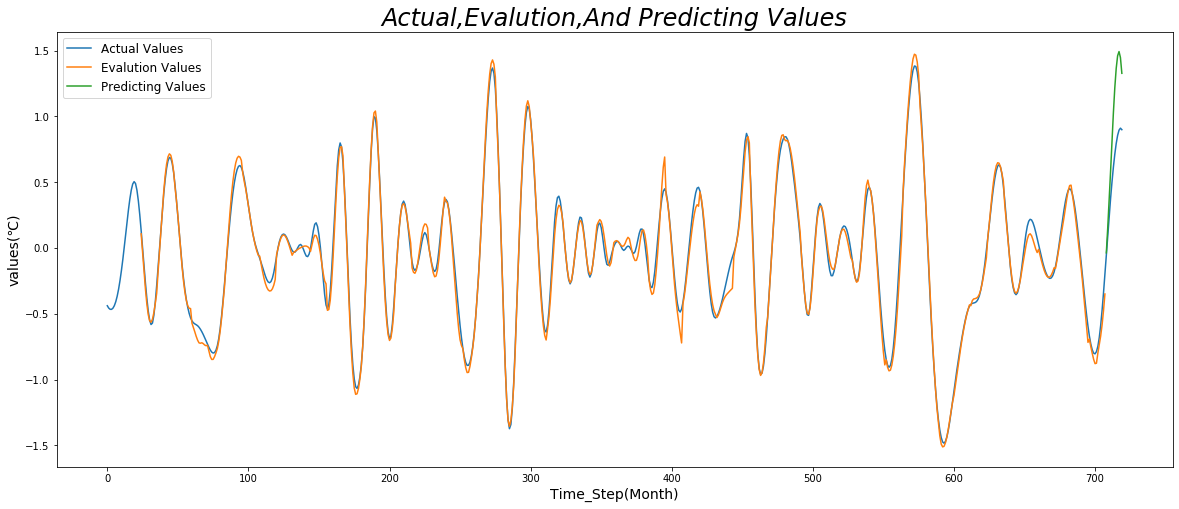

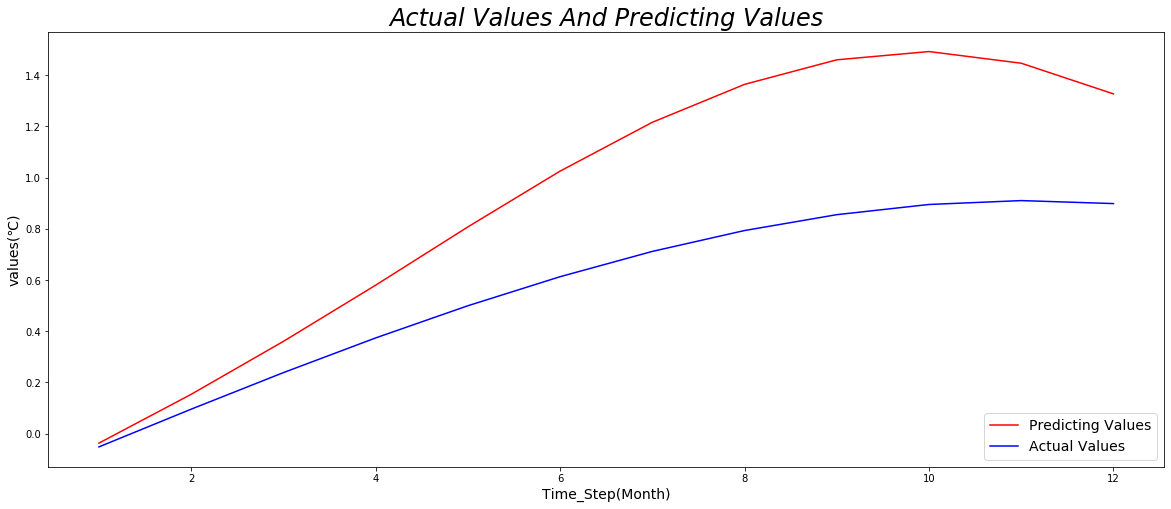

0     -0.538450
1     -0.526230
2     -0.507350
3     -0.481980
4     -0.450610
5     -0.413780
6     -0.372030
7     -0.325890
8     -0.275900
9     -0.222610
10    -0.166550
11    -0.108270
12    -0.048294
13     0.012829
14     0.074562
15     0.136370
16     0.197700
17     0.258030
18     0.316810
19     0.373510
20     0.427580
21     0.478490
22     0.525830
23     0.569200
24     0.608230
25     0.642540
26     0.671750
27     0.695490
28     0.713370
29     0.725020
         ...   
690   -0.235150
691   -0.222820
692   -0.208650
693   -0.192820
694   -0.175480
695   -0.156810
696   -0.136970
697   -0.116130
698   -0.094459
699   -0.072128
700   -0.049296
701   -0.026130
702   -0.002868
703    0.020229
704    0.042903
705    0.064891
706    0.085936
707    0.105780
708    0.124150
709    0.140810
710    0.155480
711    0.167900
712    0.177820
713    0.184970
714    0.189050
715    0.189810
716    0.186940
717    0.180130
718    0.169100
719    0.153880
Name: f3, Length: 720, d

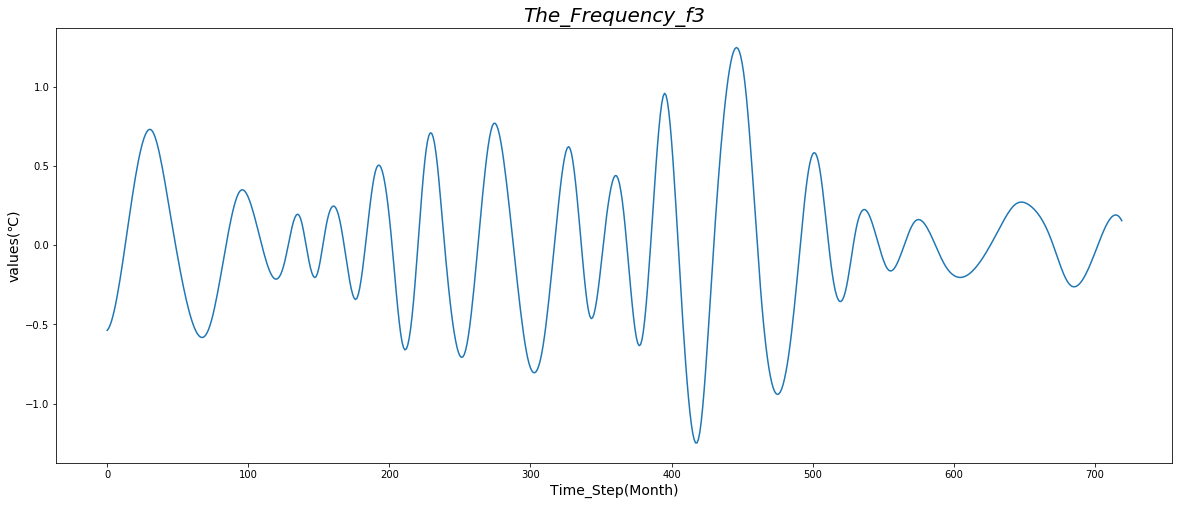

[[[-5.3845e-01]
  [-5.2623e-01]
  [-5.0735e-01]
  [-4.8198e-01]
  [-4.5061e-01]
  [-4.1378e-01]
  [-3.7203e-01]
  [-3.2589e-01]
  [-2.7590e-01]
  [-2.2261e-01]
  [-1.6655e-01]
  [-1.0827e-01]]

 [[-4.8294e-02]
  [ 1.2829e-02]
  [ 7.4562e-02]
  [ 1.3637e-01]
  [ 1.9770e-01]
  [ 2.5803e-01]
  [ 3.1681e-01]
  [ 3.7351e-01]
  [ 4.2758e-01]
  [ 4.7849e-01]
  [ 5.2583e-01]
  [ 5.6920e-01]]

 [[ 6.0823e-01]
  [ 6.4254e-01]
  [ 6.7175e-01]
  [ 6.9549e-01]
  [ 7.1337e-01]
  [ 7.2502e-01]
  [ 7.3005e-01]
  [ 7.2810e-01]
  [ 7.1888e-01]
  [ 7.0263e-01]
  [ 6.7994e-01]
  [ 6.5140e-01]]

 [[ 6.1765e-01]
  [ 5.7930e-01]
  [ 5.3698e-01]
  [ 4.9129e-01]
  [ 4.4287e-01]
  [ 3.9232e-01]
  [ 3.4028e-01]
  [ 2.8736e-01]
  [ 2.3413e-01]
  [ 1.8096e-01]
  [ 1.2808e-01]
  [ 7.5673e-02]]

 [[ 2.3922e-02]
  [-2.6981e-02]
  [-7.6848e-02]
  [-1.2549e-01]
  [-1.7272e-01]
  [-2.1835e-01]
  [-2.6219e-01]
  [-3.0405e-01]
  [-3.4374e-01]
  [-3.8107e-01]
  [-4.1587e-01]
  [-4.4793e-01]]

 [[-4.7707e-01]
  [-5.0310e-01

Epoch 1/200
 - 16s - loss: 0.1532
Epoch 2/200
 - 2s - loss: 0.1112
Epoch 3/200
 - 2s - loss: 0.0844
Epoch 4/200
 - 2s - loss: 0.0598
Epoch 5/200
 - 2s - loss: 0.0427
Epoch 6/200
 - 2s - loss: 0.0298
Epoch 7/200
 - 2s - loss: 0.0301
Epoch 8/200
 - 2s - loss: 0.0266
Epoch 9/200
 - 2s - loss: 0.0184
Epoch 10/200
 - 2s - loss: 0.0165
Epoch 11/200
 - 2s - loss: 0.0161
Epoch 12/200
 - 2s - loss: 0.0174
Epoch 13/200
 - 2s - loss: 0.0167
Epoch 14/200
 - 2s - loss: 0.0160
Epoch 15/200
 - 2s - loss: 0.0126
Epoch 16/200
 - 2s - loss: 0.0128
Epoch 17/200
 - 2s - loss: 0.0119
Epoch 18/200
 - 3s - loss: 0.0150
Epoch 19/200
 - 3s - loss: 0.0134
Epoch 20/200
 - 3s - loss: 0.0104
Epoch 21/200
 - 3s - loss: 0.0121
Epoch 22/200
 - 3s - loss: 0.0093
Epoch 23/200
 - 3s - loss: 0.0080
Epoch 24/200
 - 4s - loss: 0.0083
Epoch 25/200
 - 3s - loss: 0.0073
Epoch 26/200
 - 3s - loss: 0.0091
Epoch 27/200
 - 3s - loss: 0.0082
Epoch 28/200
 - 3s - loss: 0.0070
Epoch 29/200
 - 3s - loss: 0.0077
Epoch 30/200
 - 3s - l

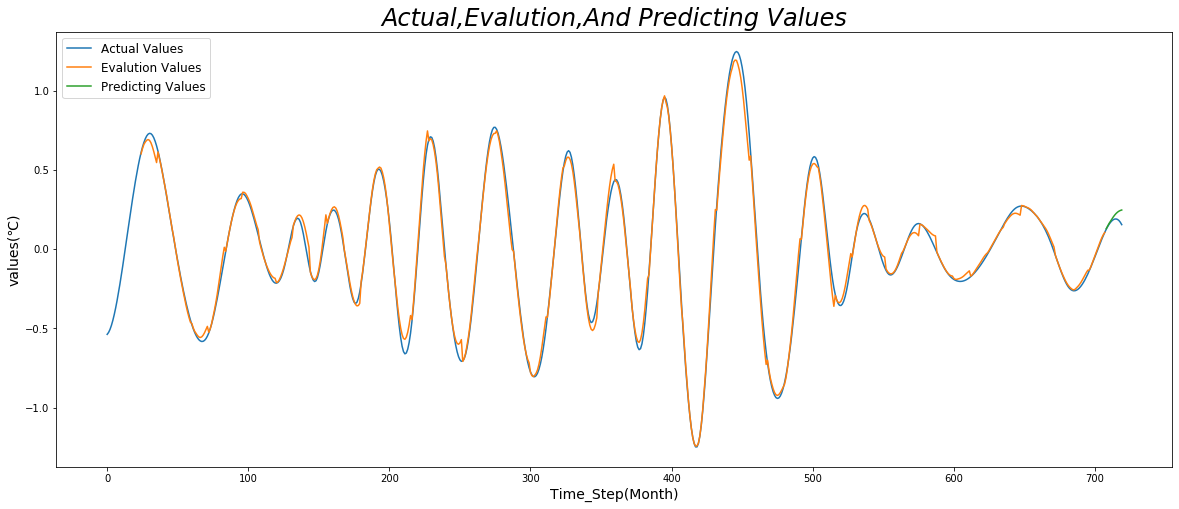

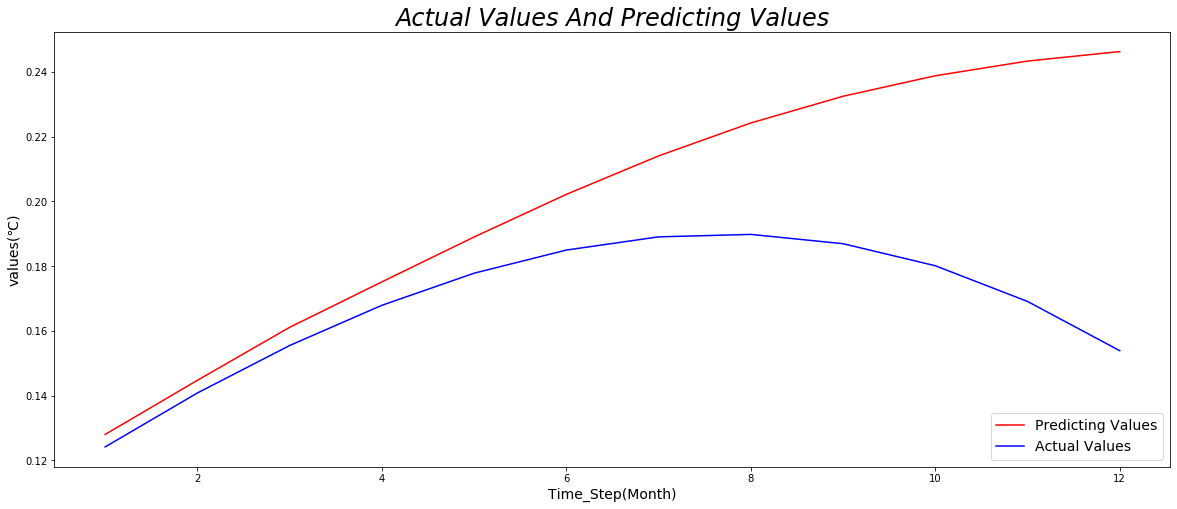

0     -0.215810
1     -0.214380
2     -0.212910
3     -0.211390
4     -0.209820
5     -0.208200
6     -0.206530
7     -0.204810
8     -0.203030
9     -0.201200
10    -0.199310
11    -0.197360
12    -0.195360
13    -0.193290
14    -0.191160
15    -0.188960
16    -0.186700
17    -0.184380
18    -0.181980
19    -0.179520
20    -0.176990
21    -0.174390
22    -0.171710
23    -0.168960
24    -0.166130
25    -0.163230
26    -0.160250
27    -0.157190
28    -0.154050
29    -0.150820
         ...   
690    0.113530
691    0.103400
692    0.093041
693    0.082458
694    0.071655
695    0.060635
696    0.049402
697    0.037958
698    0.026307
699    0.014453
700    0.002398
701   -0.009854
702   -0.022300
703   -0.034936
704   -0.047759
705   -0.060765
706   -0.073953
707   -0.087317
708   -0.100860
709   -0.114560
710   -0.128440
711   -0.142480
712   -0.156680
713   -0.171020
714   -0.185480
715   -0.200040
716   -0.214670
717   -0.229300
718   -0.243880
719   -0.258330
Name: f4, Length: 720, d

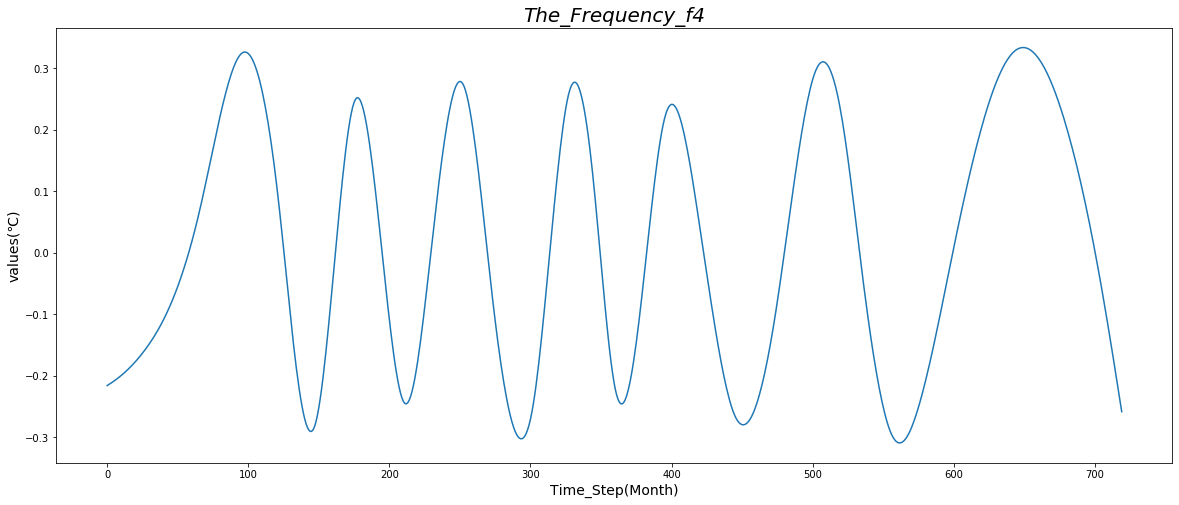

[[[-0.21581  ]
  [-0.21438  ]
  [-0.21291  ]
  [-0.21139  ]
  [-0.20982  ]
  [-0.2082   ]
  [-0.20653  ]
  [-0.20481  ]
  [-0.20303  ]
  [-0.2012   ]
  [-0.19931  ]
  [-0.19736  ]]

 [[-0.19536  ]
  [-0.19329  ]
  [-0.19116  ]
  [-0.18896  ]
  [-0.1867   ]
  [-0.18438  ]
  [-0.18198  ]
  [-0.17952  ]
  [-0.17699  ]
  [-0.17439  ]
  [-0.17171  ]
  [-0.16896  ]]

 [[-0.16613  ]
  [-0.16323  ]
  [-0.16025  ]
  [-0.15719  ]
  [-0.15405  ]
  [-0.15082  ]
  [-0.14752  ]
  [-0.14412  ]
  [-0.14063  ]
  [-0.13703  ]
  [-0.13331  ]
  [-0.12948  ]]

 [[-0.12553  ]
  [-0.12146  ]
  [-0.11725  ]
  [-0.11291  ]
  [-0.10842  ]
  [-0.10379  ]
  [-0.099013 ]
  [-0.094078 ]
  [-0.088983 ]
  [-0.083723 ]
  [-0.078293 ]
  [-0.072689 ]]

 [[-0.066905 ]
  [-0.060937 ]
  [-0.054779 ]
  [-0.048428 ]
  [-0.041877 ]
  [-0.035123 ]
  [-0.028161 ]
  [-0.020985 ]
  [-0.01359  ]
  [-0.0059729]
  [ 0.0018726]
  [ 0.0099509]]

 [[ 0.018267 ]
  [ 0.026826 ]
  [ 0.035632 ]
  [ 0.04469  ]
  [ 0.054005 ]
  [ 0.06358  ]


Epoch 1/200
 - 14s - loss: 0.0329
Epoch 2/200
 - 3s - loss: 0.0110
Epoch 3/200
 - 2s - loss: 0.0053
Epoch 4/200
 - 2s - loss: 0.0034
Epoch 5/200
 - 2s - loss: 0.0023
Epoch 6/200
 - 2s - loss: 0.0014
Epoch 7/200
 - 2s - loss: 0.0014
Epoch 8/200
 - 2s - loss: 0.0011
Epoch 9/200
 - 2s - loss: 7.3317e-04
Epoch 10/200
 - 2s - loss: 7.1578e-04
Epoch 11/200
 - 2s - loss: 0.0011
Epoch 12/200
 - 2s - loss: 8.9252e-04
Epoch 13/200
 - 2s - loss: 6.4887e-04
Epoch 14/200
 - 3s - loss: 8.0045e-04
Epoch 15/200
 - 3s - loss: 7.4656e-04
Epoch 16/200
 - 3s - loss: 5.5983e-04
Epoch 17/200
 - 3s - loss: 6.3371e-04
Epoch 18/200
 - 3s - loss: 7.1688e-04
Epoch 19/200
 - 3s - loss: 5.2837e-04
Epoch 20/200
 - 3s - loss: 8.2824e-04
Epoch 21/200
 - 3s - loss: 7.4703e-04
Epoch 22/200
 - 3s - loss: 5.6779e-04
Epoch 23/200
 - 3s - loss: 5.2442e-04
Epoch 24/200
 - 3s - loss: 6.0872e-04
Epoch 25/200
 - 3s - loss: 4.1963e-04
Epoch 26/200
 - 3s - loss: 4.6636e-04
Epoch 27/200
 - 3s - loss: 5.2707e-04
Epoch 28/200
 - 3s

(57, 12)


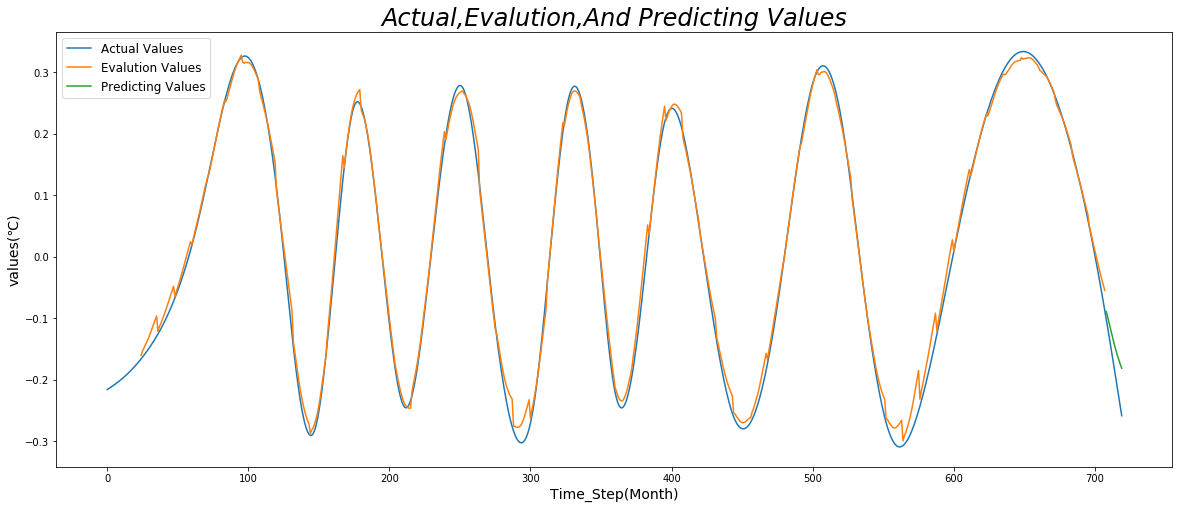

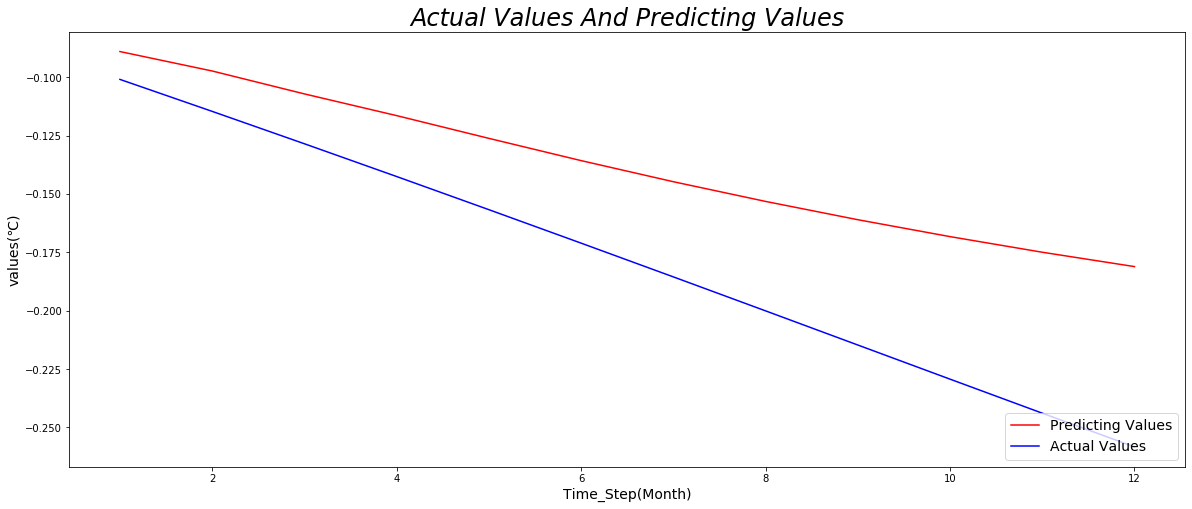

0      0.004482
1      0.003265
2      0.002159
3      0.001161
4      0.000266
5     -0.000529
6     -0.001226
7     -0.001830
8     -0.002343
9     -0.002768
10    -0.003109
11    -0.003368
12    -0.003548
13    -0.003654
14    -0.003686
15    -0.003650
16    -0.003548
17    -0.003384
18    -0.003162
19    -0.002884
20    -0.002554
21    -0.002177
22    -0.001754
23    -0.001289
24    -0.000785
25    -0.000244
26     0.000330
27     0.000934
28     0.001566
29     0.002224
         ...   
690   -0.157610
691   -0.156440
692   -0.155200
693   -0.153890
694   -0.152510
695   -0.151060
696   -0.149550
697   -0.147960
698   -0.146310
699   -0.144590
700   -0.142810
701   -0.140960
702   -0.139050
703   -0.137070
704   -0.135030
705   -0.132930
706   -0.130780
707   -0.128560
708   -0.126280
709   -0.123940
710   -0.121550
711   -0.119100
712   -0.116590
713   -0.114030
714   -0.111410
715   -0.108740
716   -0.106020
717   -0.103240
718   -0.100420
719   -0.097538
Name: f5, Length: 720, d

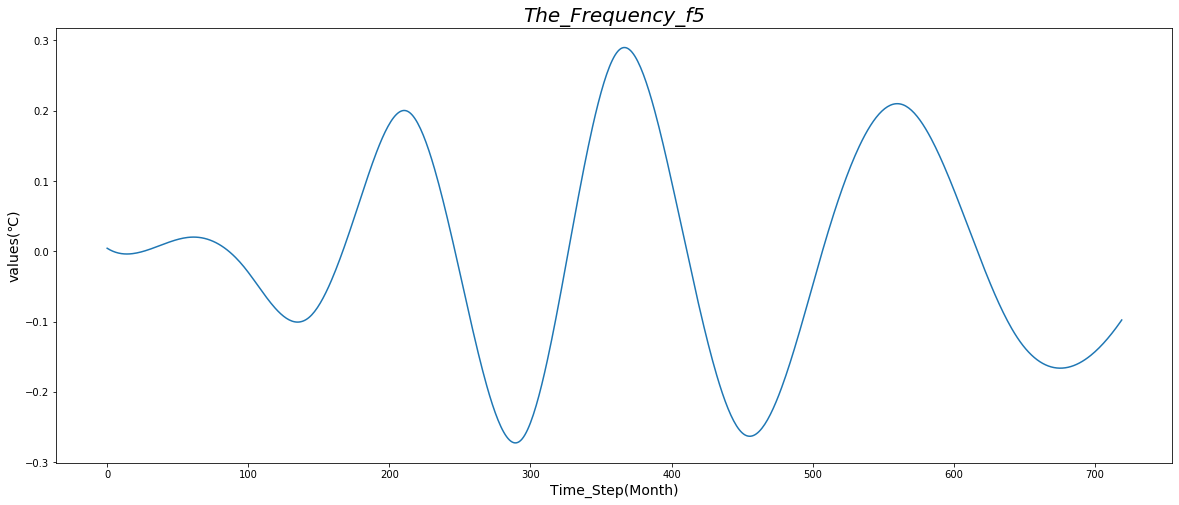

[[[ 4.4815e-03]
  [ 3.2649e-03]
  [ 2.1594e-03]
  [ 1.1610e-03]
  [ 2.6607e-04]
  [-5.2874e-04]
  [-1.2265e-03]
  [-1.8303e-03]
  [-2.3432e-03]
  [-2.7684e-03]
  [-3.1089e-03]
  [-3.3678e-03]]

 [[-3.5483e-03]
  [-3.6535e-03]
  [-3.6864e-03]
  [-3.6501e-03]
  [-3.5482e-03]
  [-3.3842e-03]
  [-3.1616e-03]
  [-2.8838e-03]
  [-2.5544e-03]
  [-2.1766e-03]
  [-1.7537e-03]
  [-1.2888e-03]]

 [[-7.8468e-04]
  [-2.4422e-04]
  [ 3.2968e-04]
  [ 9.3417e-04]
  [ 1.5665e-03]
  [ 2.2240e-03]
  [ 2.9039e-03]
  [ 3.6035e-03]
  [ 4.3202e-03]
  [ 5.0511e-03]
  [ 5.7937e-03]
  [ 6.5452e-03]]

 [[ 7.3028e-03]
  [ 8.0640e-03]
  [ 8.8259e-03]
  [ 9.5859e-03]
  [ 1.0341e-02]
  [ 1.1089e-02]
  [ 1.1827e-02]
  [ 1.2552e-02]
  [ 1.3262e-02]
  [ 1.3954e-02]
  [ 1.4624e-02]
  [ 1.5271e-02]]

 [[ 1.5892e-02]
  [ 1.6484e-02]
  [ 1.7044e-02]
  [ 1.7570e-02]
  [ 1.8058e-02]
  [ 1.8507e-02]
  [ 1.8913e-02]
  [ 1.9274e-02]
  [ 1.9587e-02]
  [ 1.9850e-02]
  [ 2.0061e-02]
  [ 2.0217e-02]]

 [[ 2.0317e-02]
  [ 2.0360e-02

Epoch 1/200
 - 10s - loss: 0.0129
Epoch 2/200
 - 3s - loss: 0.0040
Epoch 3/200
 - 3s - loss: 0.0011
Epoch 4/200
 - 3s - loss: 4.5386e-04
Epoch 5/200
 - 2s - loss: 2.3026e-04
Epoch 6/200
 - 2s - loss: 1.4293e-04
Epoch 7/200
 - 2s - loss: 1.2867e-04
Epoch 8/200
 - 2s - loss: 9.2006e-05
Epoch 9/200
 - 4s - loss: 8.3161e-05
Epoch 10/200
 - 4s - loss: 8.3859e-05
Epoch 11/200
 - 4s - loss: 6.3943e-05
Epoch 12/200
 - 3s - loss: 5.7778e-05
Epoch 13/200
 - 3s - loss: 1.1410e-04
Epoch 14/200
 - 3s - loss: 8.6668e-05
Epoch 15/200
 - 3s - loss: 6.4773e-05
Epoch 16/200
 - 3s - loss: 5.3786e-05
Epoch 17/200
 - 3s - loss: 7.1104e-05
Epoch 18/200
 - 3s - loss: 8.0323e-05
Epoch 19/200
 - 3s - loss: 8.4249e-05
Epoch 20/200
 - 3s - loss: 8.6292e-05
Epoch 21/200
 - 3s - loss: 8.7493e-05
Epoch 22/200
 - 3s - loss: 7.1257e-05
Epoch 23/200
 - 3s - loss: 8.8086e-05
Epoch 24/200
 - 3s - loss: 7.4306e-05
Epoch 25/200
 - 3s - loss: 9.5048e-05
Epoch 26/200
 - 3s - loss: 6.3322e-05
Epoch 27/200
 - 3s - loss: 4.799

(57, 12)


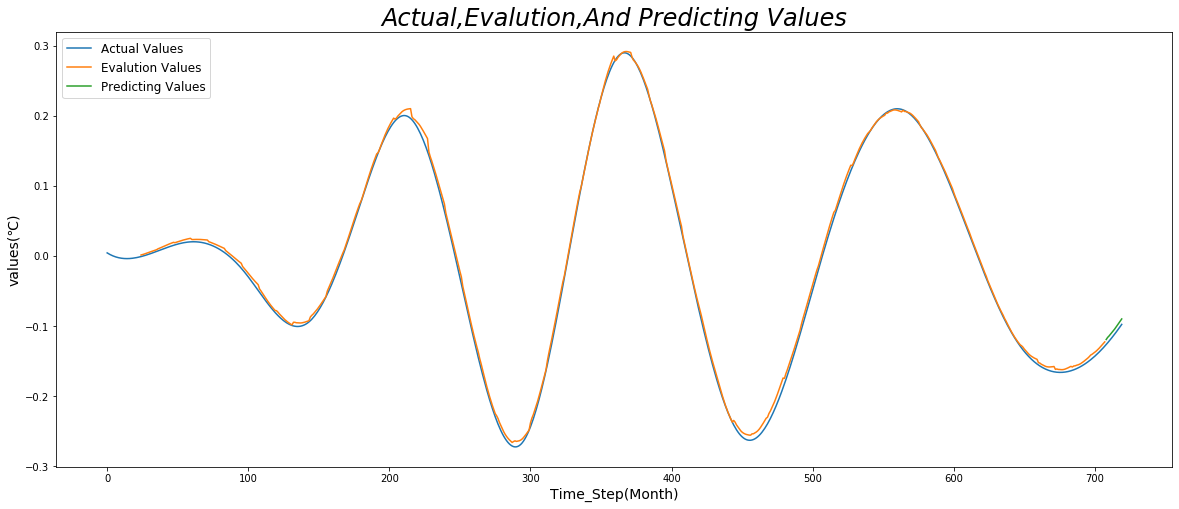

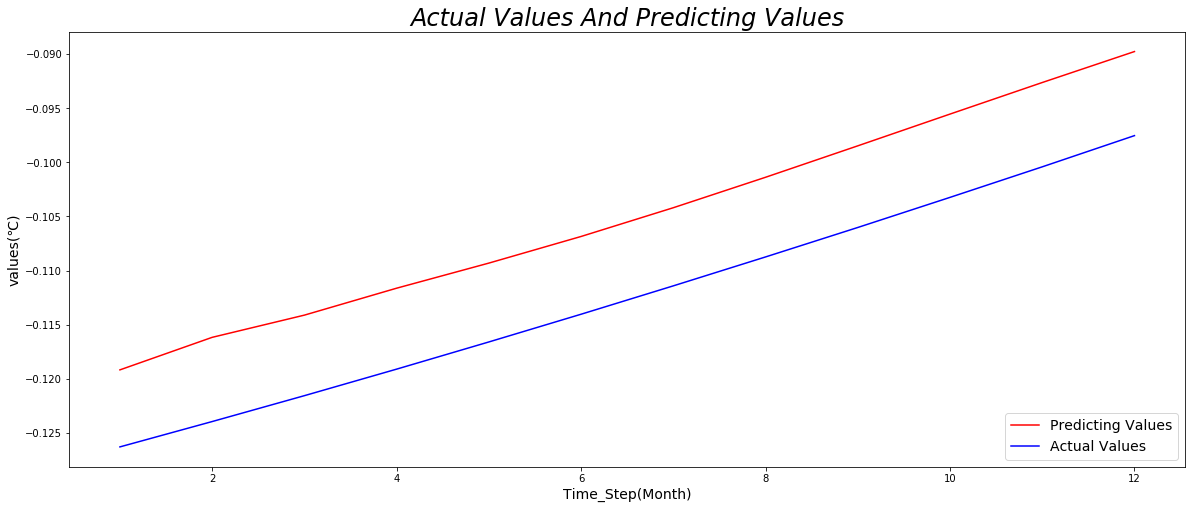

0     -0.12887
1     -0.12956
2     -0.13022
3     -0.13084
4     -0.13142
5     -0.13198
6     -0.13249
7     -0.13297
8     -0.13342
9     -0.13382
10    -0.13418
11    -0.13451
12    -0.13479
13    -0.13504
14    -0.13524
15    -0.13539
16    -0.13551
17    -0.13557
18    -0.13559
19    -0.13557
20    -0.13549
21    -0.13536
22    -0.13519
23    -0.13496
24    -0.13468
25    -0.13434
26    -0.13395
27    -0.13351
28    -0.13302
29    -0.13247
        ...   
690   -0.21738
691   -0.21698
692   -0.21655
693   -0.21609
694   -0.21561
695   -0.21510
696   -0.21457
697   -0.21401
698   -0.21343
699   -0.21283
700   -0.21220
701   -0.21154
702   -0.21087
703   -0.21017
704   -0.20945
705   -0.20870
706   -0.20794
707   -0.20715
708   -0.20634
709   -0.20552
710   -0.20467
711   -0.20380
712   -0.20292
713   -0.20201
714   -0.20109
715   -0.20014
716   -0.19918
717   -0.19821
718   -0.19721
719   -0.19620
Name: f6, Length: 720, dtype: float64
(720,)


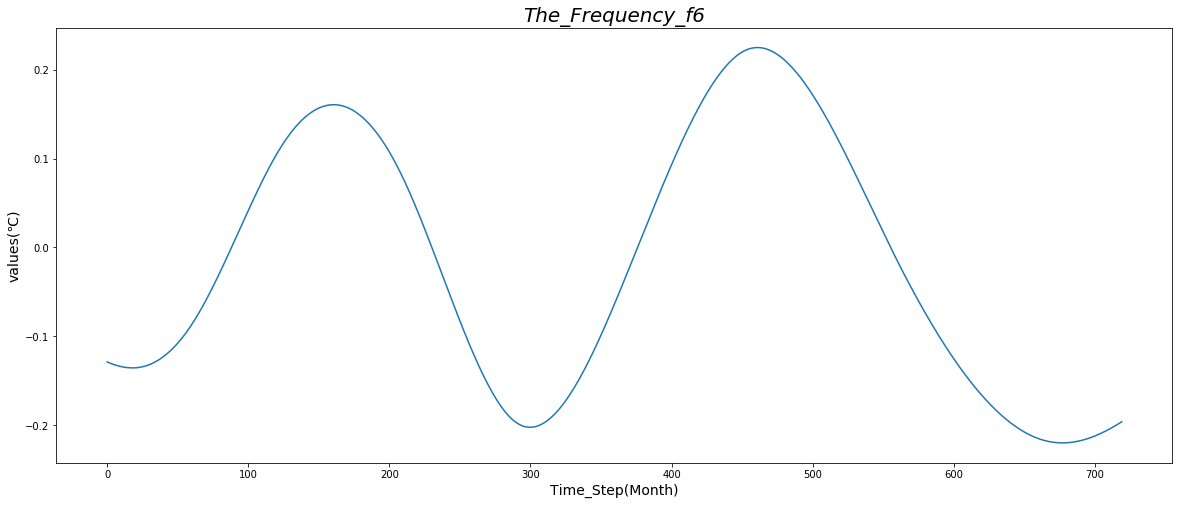

[[[-0.12887   ]
  [-0.12956   ]
  [-0.13022   ]
  [-0.13084   ]
  [-0.13142   ]
  [-0.13198   ]
  [-0.13249   ]
  [-0.13297   ]
  [-0.13342   ]
  [-0.13382   ]
  [-0.13418   ]
  [-0.13451   ]]

 [[-0.13479   ]
  [-0.13504   ]
  [-0.13524   ]
  [-0.13539   ]
  [-0.13551   ]
  [-0.13557   ]
  [-0.13559   ]
  [-0.13557   ]
  [-0.13549   ]
  [-0.13536   ]
  [-0.13519   ]
  [-0.13496   ]]

 [[-0.13468   ]
  [-0.13434   ]
  [-0.13395   ]
  [-0.13351   ]
  [-0.13302   ]
  [-0.13247   ]
  [-0.13187   ]
  [-0.13121   ]
  [-0.13049   ]
  [-0.12972   ]
  [-0.12889   ]
  [-0.12801   ]]

 [[-0.12707   ]
  [-0.12608   ]
  [-0.12502   ]
  [-0.12391   ]
  [-0.12274   ]
  [-0.12151   ]
  [-0.12022   ]
  [-0.11888   ]
  [-0.11747   ]
  [-0.116     ]
  [-0.11448   ]
  [-0.11289   ]]

 [[-0.11124   ]
  [-0.10953   ]
  [-0.10776   ]
  [-0.10593   ]
  [-0.10404   ]
  [-0.10208   ]
  [-0.10006   ]
  [-0.097974  ]
  [-0.095827  ]
  [-0.093616  ]
  [-0.091342  ]
  [-0.089005  ]]

 [[-0.086605  ]
  [-0.084145  

Epoch 1/200
 - 11s - loss: 0.0117
Epoch 2/200
 - 3s - loss: 0.0053
Epoch 3/200
 - 3s - loss: 0.0031
Epoch 4/200
 - 3s - loss: 0.0014
Epoch 5/200
 - 4s - loss: 5.6955e-04
Epoch 6/200
 - 4s - loss: 2.2190e-04
Epoch 7/200
 - 4s - loss: 1.5054e-04
Epoch 8/200
 - 4s - loss: 7.1436e-05
Epoch 9/200
 - 4s - loss: 4.5843e-05
Epoch 10/200
 - 4s - loss: 3.3257e-05
Epoch 11/200
 - 3s - loss: 3.9762e-05
Epoch 12/200
 - 3s - loss: 2.3608e-05
Epoch 13/200
 - 3s - loss: 2.2766e-05
Epoch 14/200
 - 3s - loss: 2.8367e-05
Epoch 15/200
 - 3s - loss: 2.6041e-05
Epoch 16/200
 - 3s - loss: 1.8489e-05
Epoch 17/200
 - 3s - loss: 1.5572e-05
Epoch 18/200
 - 3s - loss: 1.7074e-05
Epoch 19/200
 - 4s - loss: 4.3152e-05
Epoch 20/200
 - 3s - loss: 4.2353e-05
Epoch 21/200
 - 3s - loss: 2.0019e-05
Epoch 22/200
 - 3s - loss: 9.6706e-06
Epoch 23/200
 - 3s - loss: 9.5724e-06
Epoch 24/200
 - 3s - loss: 9.3266e-06
Epoch 25/200
 - 3s - loss: 9.8468e-06
Epoch 26/200
 - 3s - loss: 9.0780e-06
Epoch 27/200
 - 3s - loss: 9.5784e-0

(57, 12)


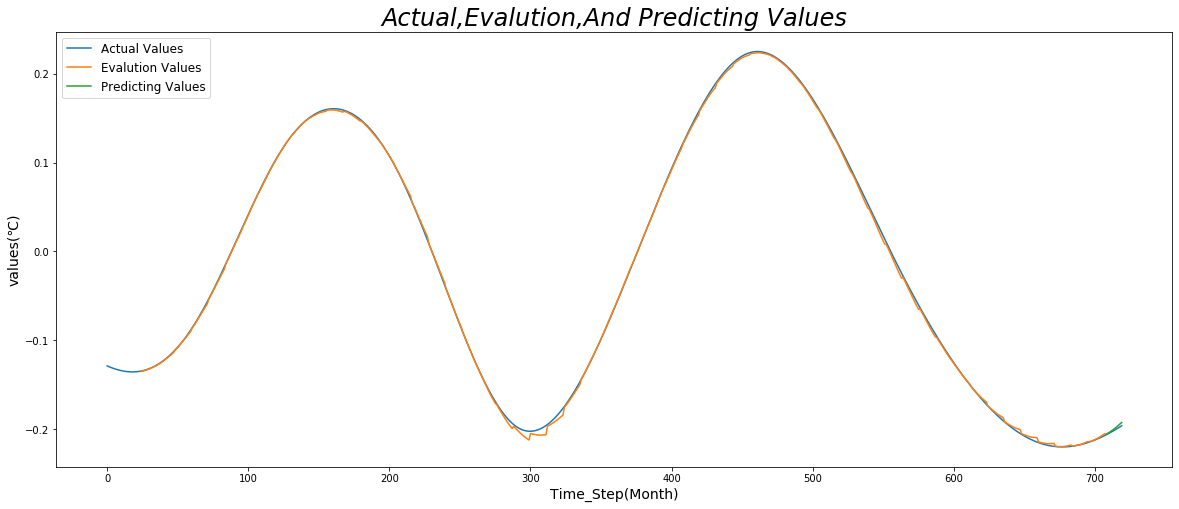

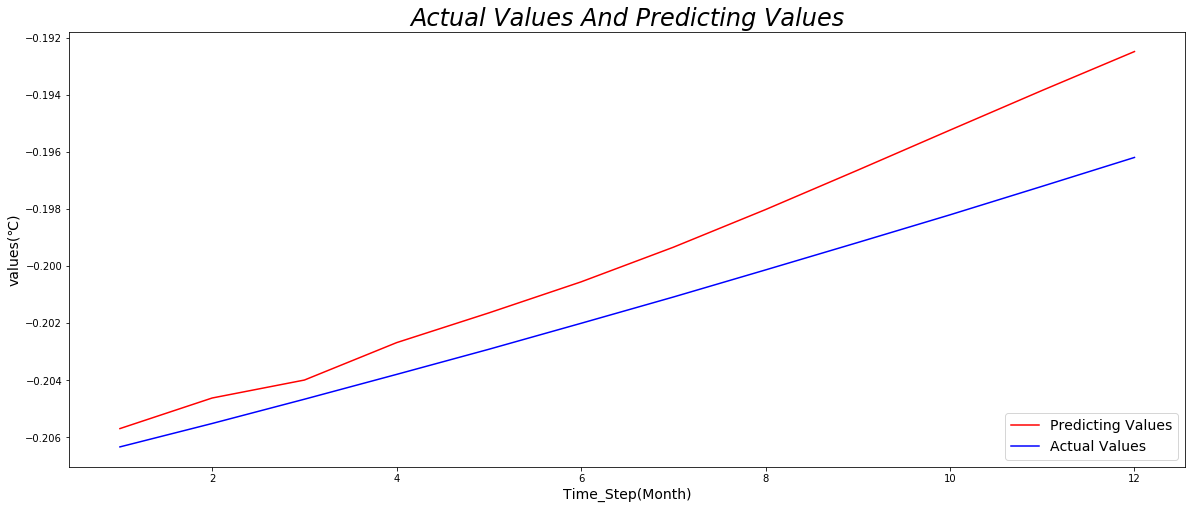

0      0.051841
1      0.051858
2      0.051870
3      0.051877
4      0.051878
5      0.051875
6      0.051866
7      0.051851
8      0.051832
9      0.051807
10     0.051776
11     0.051741
12     0.051700
13     0.051653
14     0.051601
15     0.051543
16     0.051480
17     0.051411
18     0.051337
19     0.051257
20     0.051172
21     0.051081
22     0.050984
23     0.050882
24     0.050774
25     0.050660
26     0.050542
27     0.050418
28     0.050288
29     0.050153
         ...   
690    0.044056
691    0.044092
692    0.044124
693    0.044154
694    0.044180
695    0.044204
696    0.044224
697    0.044242
698    0.044256
699    0.044267
700    0.044276
701    0.044281
702    0.044283
703    0.044283
704    0.044279
705    0.044273
706    0.044263
707    0.044251
708    0.044236
709    0.044218
710    0.044197
711    0.044174
712    0.044147
713    0.044118
714    0.044086
715    0.044051
716    0.044013
717    0.043973
718    0.043930
719    0.043884
Name: f7, Length: 720, d

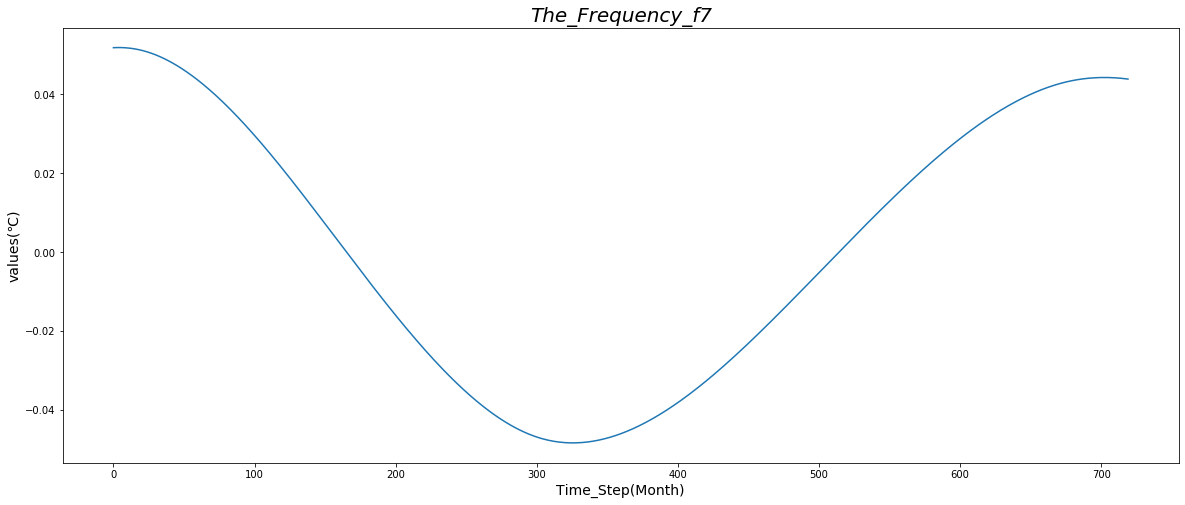

[[[ 5.1841e-02]
  [ 5.1858e-02]
  [ 5.1870e-02]
  [ 5.1877e-02]
  [ 5.1878e-02]
  [ 5.1875e-02]
  [ 5.1866e-02]
  [ 5.1851e-02]
  [ 5.1832e-02]
  [ 5.1807e-02]
  [ 5.1776e-02]
  [ 5.1741e-02]]

 [[ 5.1700e-02]
  [ 5.1653e-02]
  [ 5.1601e-02]
  [ 5.1543e-02]
  [ 5.1480e-02]
  [ 5.1411e-02]
  [ 5.1337e-02]
  [ 5.1257e-02]
  [ 5.1172e-02]
  [ 5.1081e-02]
  [ 5.0984e-02]
  [ 5.0882e-02]]

 [[ 5.0774e-02]
  [ 5.0660e-02]
  [ 5.0542e-02]
  [ 5.0418e-02]
  [ 5.0288e-02]
  [ 5.0153e-02]
  [ 5.0013e-02]
  [ 4.9868e-02]
  [ 4.9718e-02]
  [ 4.9562e-02]
  [ 4.9402e-02]
  [ 4.9236e-02]]

 [[ 4.9065e-02]
  [ 4.8889e-02]
  [ 4.8709e-02]
  [ 4.8523e-02]
  [ 4.8333e-02]
  [ 4.8138e-02]
  [ 4.7938e-02]
  [ 4.7733e-02]
  [ 4.7524e-02]
  [ 4.7310e-02]
  [ 4.7091e-02]
  [ 4.6868e-02]]

 [[ 4.6640e-02]
  [ 4.6408e-02]
  [ 4.6171e-02]
  [ 4.5930e-02]
  [ 4.5685e-02]
  [ 4.5435e-02]
  [ 4.5181e-02]
  [ 4.4923e-02]
  [ 4.4660e-02]
  [ 4.4394e-02]
  [ 4.4123e-02]
  [ 4.3848e-02]]

 [[ 4.3570e-02]
  [ 4.3287e-02

Epoch 1/200
 - 9s - loss: 0.0010
Epoch 2/200
 - 4s - loss: 2.9037e-04
Epoch 3/200
 - 4s - loss: 1.4956e-04
Epoch 4/200
 - 4s - loss: 9.6510e-05
Epoch 5/200
 - 4s - loss: 6.9257e-05
Epoch 6/200
 - 3s - loss: 5.3870e-05
Epoch 7/200
 - 4s - loss: 4.7316e-05
Epoch 8/200
 - 3s - loss: 3.8205e-05
Epoch 9/200
 - 5s - loss: 3.1277e-05
Epoch 10/200
 - 6s - loss: 3.0466e-05
Epoch 11/200
 - 5s - loss: 3.5473e-05
Epoch 12/200
 - 4s - loss: 2.6970e-05
Epoch 13/200
 - 4s - loss: 2.1673e-05
Epoch 14/200
 - 4s - loss: 2.2581e-05
Epoch 15/200
 - 4s - loss: 2.1358e-05
Epoch 16/200
 - 4s - loss: 1.6585e-05
Epoch 17/200
 - 4s - loss: 1.7495e-05
Epoch 18/200
 - 4s - loss: 1.5096e-05
Epoch 19/200
 - 4s - loss: 1.0031e-05
Epoch 20/200
 - 3s - loss: 6.8993e-06
Epoch 21/200
 - 4s - loss: 5.9603e-06
Epoch 22/200
 - 4s - loss: 2.9700e-06
Epoch 23/200
 - 3s - loss: 3.2267e-06
Epoch 24/200
 - 3s - loss: 2.1174e-06
Epoch 25/200
 - 3s - loss: 8.9041e-07
Epoch 26/200
 - 3s - loss: 6.2367e-07
Epoch 27/200
 - 3s - loss

(57, 12)


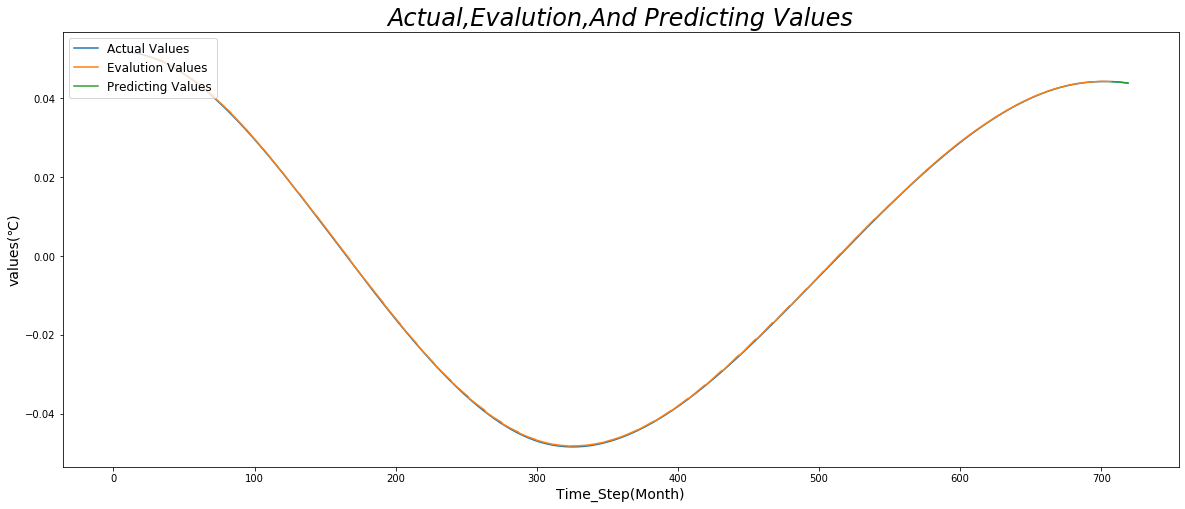

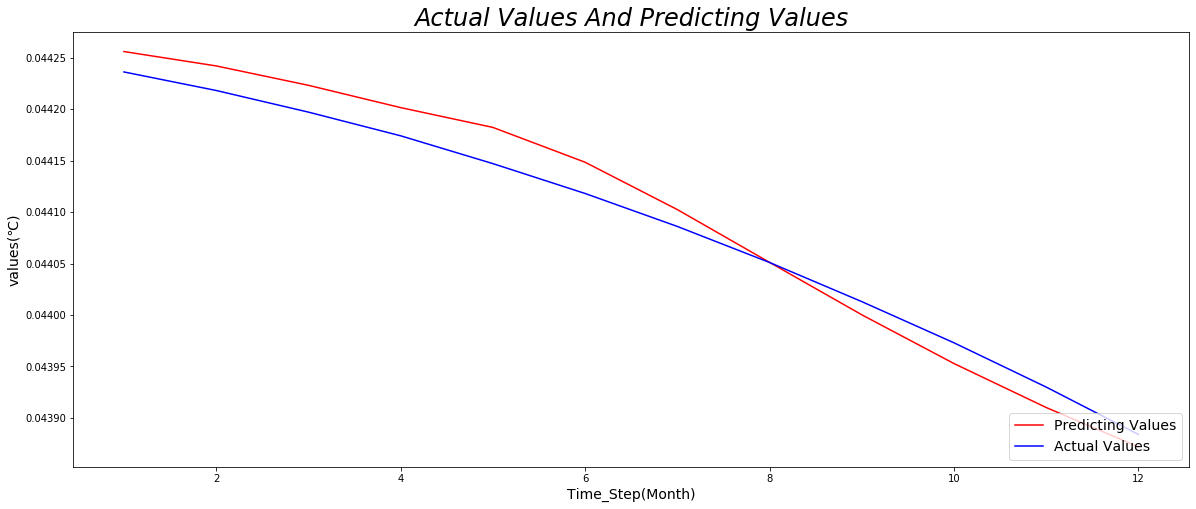

0      0.085791
1      0.085784
2      0.085777
3      0.085769
4      0.085762
5      0.085755
6      0.085747
7      0.085740
8      0.085733
9      0.085725
10     0.085718
11     0.085710
12     0.085703
13     0.085695
14     0.085687
15     0.085680
16     0.085672
17     0.085664
18     0.085657
19     0.085649
20     0.085641
21     0.085633
22     0.085625
23     0.085618
24     0.085610
25     0.085602
26     0.085594
27     0.085586
28     0.085578
29     0.085570
         ...   
690    0.078256
691    0.078249
692    0.078241
693    0.078234
694    0.078226
695    0.078219
696    0.078212
697    0.078204
698    0.078197
699    0.078190
700    0.078182
701    0.078175
702    0.078168
703    0.078161
704    0.078154
705    0.078146
706    0.078139
707    0.078132
708    0.078125
709    0.078118
710    0.078111
711    0.078104
712    0.078098
713    0.078091
714    0.078084
715    0.078077
716    0.078070
717    0.078064
718    0.078057
719    0.078050
Name: f8, Length: 720, d

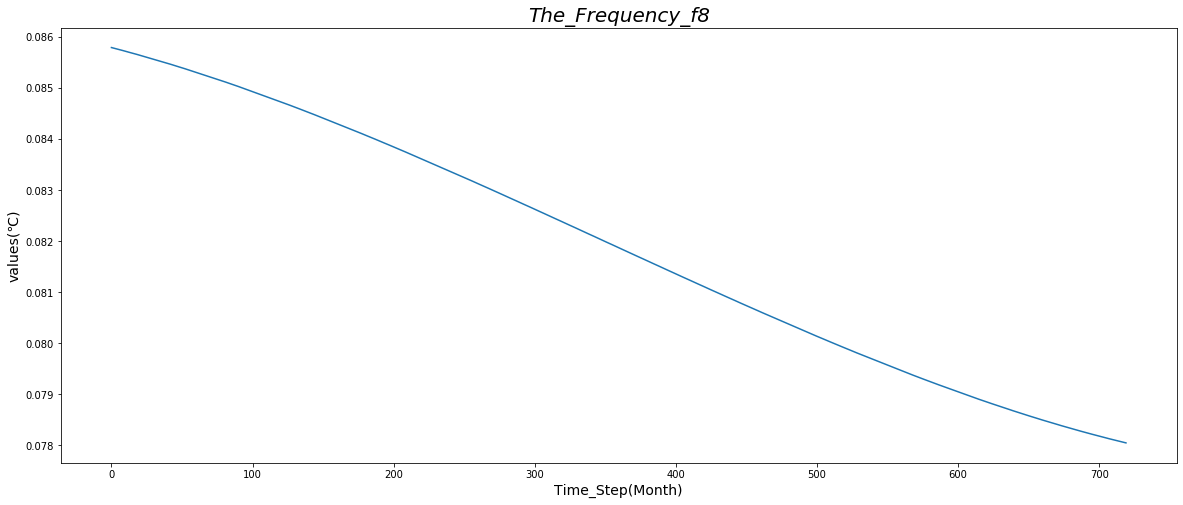

[[[0.085791]
  [0.085784]
  [0.085777]
  [0.085769]
  [0.085762]
  [0.085755]
  [0.085747]
  [0.08574 ]
  [0.085733]
  [0.085725]
  [0.085718]
  [0.08571 ]]

 [[0.085703]
  [0.085695]
  [0.085687]
  [0.08568 ]
  [0.085672]
  [0.085664]
  [0.085657]
  [0.085649]
  [0.085641]
  [0.085633]
  [0.085625]
  [0.085618]]

 [[0.08561 ]
  [0.085602]
  [0.085594]
  [0.085586]
  [0.085578]
  [0.08557 ]
  [0.085562]
  [0.085554]
  [0.085545]
  [0.085537]
  [0.085529]
  [0.085521]]

 [[0.085513]
  [0.085504]
  [0.085496]
  [0.085488]
  [0.085479]
  [0.085471]
  [0.085463]
  [0.085454]
  [0.085446]
  [0.085437]
  [0.085429]
  [0.08542 ]]

 [[0.085411]
  [0.085403]
  [0.085394]
  [0.085386]
  [0.085377]
  [0.085368]
  [0.085359]
  [0.085351]
  [0.085342]
  [0.085333]
  [0.085324]
  [0.085315]]

 [[0.085306]
  [0.085297]
  [0.085289]
  [0.08528 ]
  [0.085271]
  [0.085262]
  [0.085252]
  [0.085243]
  [0.085234]
  [0.085225]
  [0.085216]
  [0.085207]]

 [[0.085198]
  [0.085188]
  [0.085179]
  [0.08517 ]


Epoch 1/200
 - 21s - loss: 6.7919e-04
Epoch 2/200
 - 4s - loss: 1.4527e-05
Epoch 3/200
 - 4s - loss: 6.9630e-06
Epoch 4/200
 - 4s - loss: 5.8360e-06
Epoch 5/200
 - 4s - loss: 5.5389e-06
Epoch 6/200
 - 4s - loss: 5.6672e-06
Epoch 7/200
 - 3s - loss: 5.4690e-06
Epoch 8/200
 - 4s - loss: 5.4271e-06
Epoch 9/200
 - 3s - loss: 5.5280e-06
Epoch 10/200
 - 3s - loss: 5.4958e-06
Epoch 11/200
 - 3s - loss: 5.5859e-06
Epoch 12/200
 - 3s - loss: 5.6015e-06
Epoch 13/200
 - 3s - loss: 5.4006e-06
Epoch 14/200
 - 3s - loss: 5.7224e-06
Epoch 15/200
 - 3s - loss: 5.3126e-06
Epoch 16/200
 - 3s - loss: 5.4298e-06
Epoch 17/200
 - 3s - loss: 5.2858e-06
Epoch 18/200
 - 3s - loss: 5.5720e-06
Epoch 19/200
 - 3s - loss: 5.2373e-06
Epoch 20/200
 - 4s - loss: 5.3994e-06
Epoch 21/200
 - 4s - loss: 5.7122e-06
Epoch 22/200
 - 4s - loss: 5.9634e-06
Epoch 23/200
 - 4s - loss: 6.9091e-06
Epoch 24/200
 - 3s - loss: 5.8994e-06
Epoch 25/200
 - 4s - loss: 5.6906e-06
Epoch 26/200
 - 3s - loss: 5.2899e-06
Epoch 27/200
 - 3s -

(57, 12)


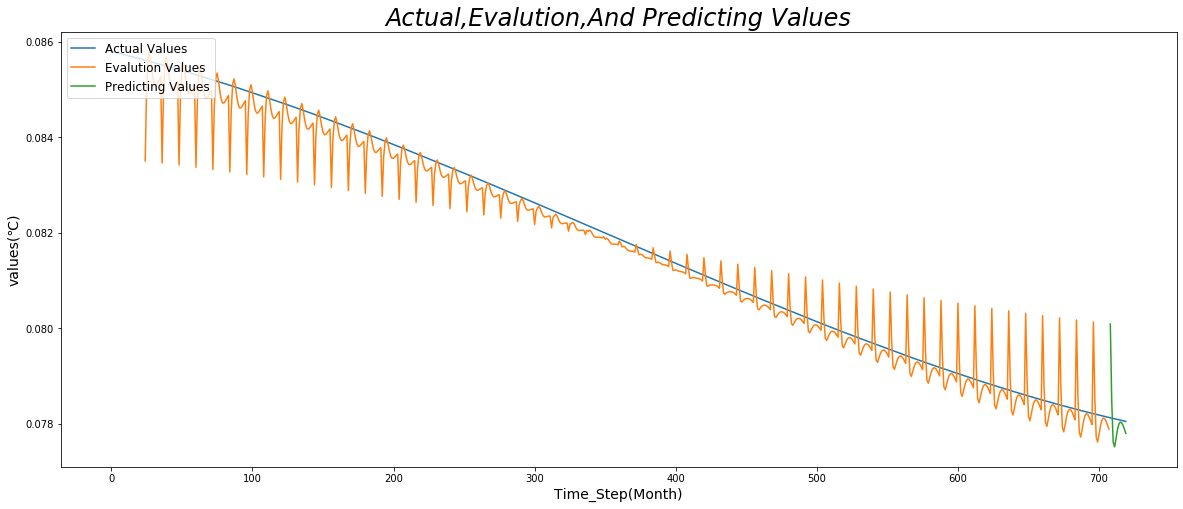

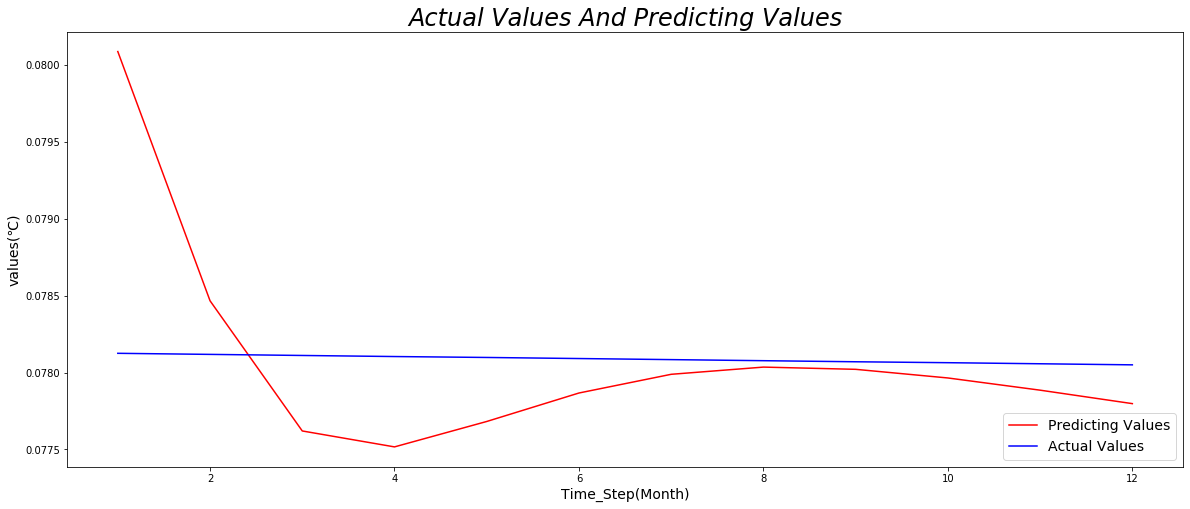

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-108]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.08008756]
 [0.0784667 ]
 [0.07762003]
 [0.07751638]
 [0.07768166]
 [0.07786682]
 [0.07798848]
 [0.07803532]
 [0.07802085]
 [0.07796463]
 [0.07788527]
 [0.07779773]]
[array([-0.035619  ,  0.00085938,  0.048474  ,  0.1295    ,  0.16711   ,
        0.18269   , -0.0070328 , -0.27565   , -0.29169   , -0.14083   ,
        0.089041  ,  0.41071   ]), array([-0.5259  , -0.61576 , -0.61016 , -0.52834 , -0.39074 , -0.21603 ,
       -0.018192,  0.17908 ,  0.34705 ,  0.4741  ,  0.55087 ,  0.56674 ]), array([-0.05152 ,  0.095783,  0.23856 ,  0.37404 ,  0.49975 ,  0.61322 ,
        0.71198 ,  0.79356 ,  0.8555  ,  0.89532 ,  0.91051 ,  0.89881 ]), array([0.12415, 0.14081, 0.15548, 0.1679 , 0.17782, 0.18497, 0.18905,
       0.18981, 0.18694, 0.18013, 0.1691 , 0.15388]), array([-0.10086, -0.11456, -0.12844, -0.14248, -0.15668, -0.17102,
       -0.18548, -0.20004, -0.21467, -0.2293 , -0.24388, -0.25833]), array([-0.12628 , -0.12394 , -0.12155 , -0.1191  , -0.11659 , -0.11403 ,
       -0.11141 , -0.1

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.035619    0.00085938  0.048474    0.1295      0.16711     0.18269
 -0.0070328  -0.27565    -0.29169    -0.14083     0.089041    0.41071   ]
[[-0.035619  ]
 [ 0.00085938]
 [ 0.048474  ]
 [ 0.1295    ]
 [ 0.16711   ]
 [ 0.18269   ]
 [-0.0070328 ]
 [-0.27565   ]
 [-0.29169   ]
 [-0.14083   ]
 [ 0.089041  ]
 [ 0.41071   ]]
[[-0.04]
 [ 0.  ]
 [ 0.05]
 [ 0.13]
 [ 0.17]
 [ 0.18]
 [-0.01]
 [-0.28]
 [-0.29]
 [-0.14]
 [ 0.09]
 [ 0.41]]
-----------------------------------
observe value:[-0.5259   -0.61576  -0.61016  -0.52834  -0.39074  -0.21603  -0.018192
  0.17908   0.34705   0.4741    0.55087   0.56674 ]
[[-0.561519  ]
 [-0.61490062]
 [-0.561686  ]
 [-0.39884   ]
 [-0.22363   ]
 [-0.03334   ]
 [-0.0252248 ]
 [-0.09657   ]
 [ 0.05536   ]
 [ 0.33327   ]
 [ 0.639911  ]
 [ 0.97745   ]]
[[-0.56]
 [-0.61]
 [-0.56]
 [-0.4 ]
 [-0.22]
 [-0.03]
 [-0.03]
 [-0.1 ]
 [ 0.06]
 [ 0.33]
 [ 0.64]
 [ 0.98]]
-----------------------------------
observe value:[-0.05152   0.095783  0.23856   0.37404

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.04290385 -0.04086279  0.00388374  0.04482875  0.04720174 -0.00019596
 -0.07243487 -0.10494357 -0.04827952  0.06282172  0.13314609  0.09638165]
[-0.04290385 -0.04086279  0.00388374  0.04482875  0.04720174 -0.00019596
 -0.07243487 -0.10494357 -0.04827952  0.06282172  0.13314609  0.09638165]
the 1 frequence:
predicted_value:[-0.5642021  -0.76895887 -0.7569356  -0.49004966 -0.13493098  0.16644476
  0.37433252  0.49118552  0.5131052   0.44357774  0.30594942  0.13693568]
[-0.60710592 -0.80982165 -0.75305185 -0.44522091 -0.08772925  0.1662488
  0.30189764  0.38624194  0.46482569  0.50639945  0.43909551  0.23331733]
the 2 frequence:
predicted_value:[-0.03681895  0.15378636  0.36061203  0.58004034  0.8076673   1.0255721
  1.2162837   1.3644532   1.460338    1.4926424   1.4470397   1.3272699 ]
[-0.64392487 -0.65603529 -0.39243982  0.13481943  0.71993807  1.19182086
  1.51818132  1.75069514  1.92516369  1.99904186  1.88613

[[-0.8]
 [-0.7]
 [-0.5]
 [-0.2]
 [ 0.1]
 [ 0.4]
 [ 0.5]
 [ 0.5]
 [ 0.7]
 [ 1. ]
 [ 1.3]
 [ 1.6]]
[-8.05374447e-01 -8.06648318e-01 -5.34687331e-01  9.86073166e-04
  5.93737464e-01  1.07295251e+00  1.40609948e+00  1.64446810e+00
  1.82357622e+00  1.90076942e+00  1.78989483e+00  1.46523613e+00]


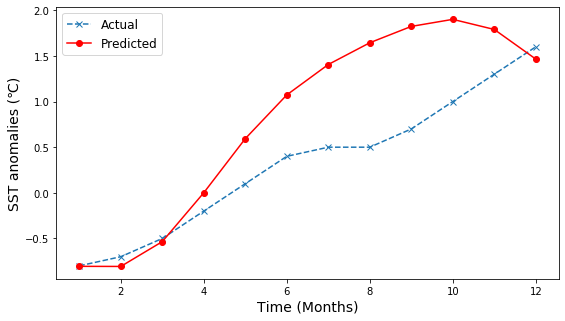

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 
